<a href="https://githubtocolab.com/EEESlab/LAB1-APAI23-DNN-definition-and-training/blob/main/APAI23-LAB1-DNN-definition-and-training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

# **LAB1 APAI: DNN Definition & Training**

**Credits**: *Lorenzo Lamberti, Davide Nadalini, Luca Bompani, Luka Macan*, Francesco Conti
*(University of Bologna)*

**Contacts**: *lorenzo.lamberti@unibo.it*, *d.nadalini@unibo.it*



## **In this Hands-on session:**

A first-time user of Pytorch framework will learn how to define, train, and test a neural network over the Fashion-MNIST dataset.

### Tasks:

---

1.  PyTorch definition of a NN model;
2. Count network’s parameters and MAC operations;
3. Data loader for Fashion-MNIST
4. Code for testing a neural network on Fashion MNIST dataset;
5. Code for training a neural network on Fashion MNIST;
6. Save and load model’s trained weights;
---




## Let's start !

Let us start by installing dependencies...

**Note:** if you need to instal more packages, add them here! (but remember to also import them afterwards!)

In [1]:
#@title Install dependencies { form-width: "20%" }

# these ones should already be available
!pip install numpy
!pip install tqdm
!pip install pillow

!pip install torch
!pip install torchvision

!pip install thop
!pip install matplotlib
!pip install scikit-learn
!pip install torchinfo

# You will need these if running on a private server (no colab)
# !pip install jupyter
# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension



## Imports:
Now we import some packages  we will need:

In [2]:
#basic
import os
from os.path import join
import numpy as np
from tqdm import tqdm
import time

#plotting
import matplotlib.pyplot as plt

#torch
import torch; print('\nPyTorch version in use:', torch.__version__, '\ncuda avail: ', torch.cuda.is_available())
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

#torchvision
import torchvision
from torchvision import transforms, datasets

# others
from copy import deepcopy
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect

!pip install thop
from thop import profile



PyTorch version in use: 2.0.1+cu118 
cuda avail:  True


<ipython-input-2-eb41942d01cf>:24: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Set device
Between "cuda" and "cpu"

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: %s' % device)

Device: cuda


# **Task 1:** Creating a Model
---



The first real step is to define the network topology. We will define a custom one.

* Use `torch.nn.Module`,
* **IMPORTANT:** Instantiate a separate `torch.nn.Module` for each node in your topology; This is mandatory for parametric modules (e.g., `torch.nn.Conv2d`, `nn.Linear`,`nn.BatchNorm2d`).

---

You can use the following modules:
* `nn.Conv2d`
* `nn.Linear`
* `nn.BatchNorm2d`
* `nn.ReLU`
* `nn.MaxPool2d`
* `nn.LogSoftmax`



**You must define the NN topology following this diagram:**

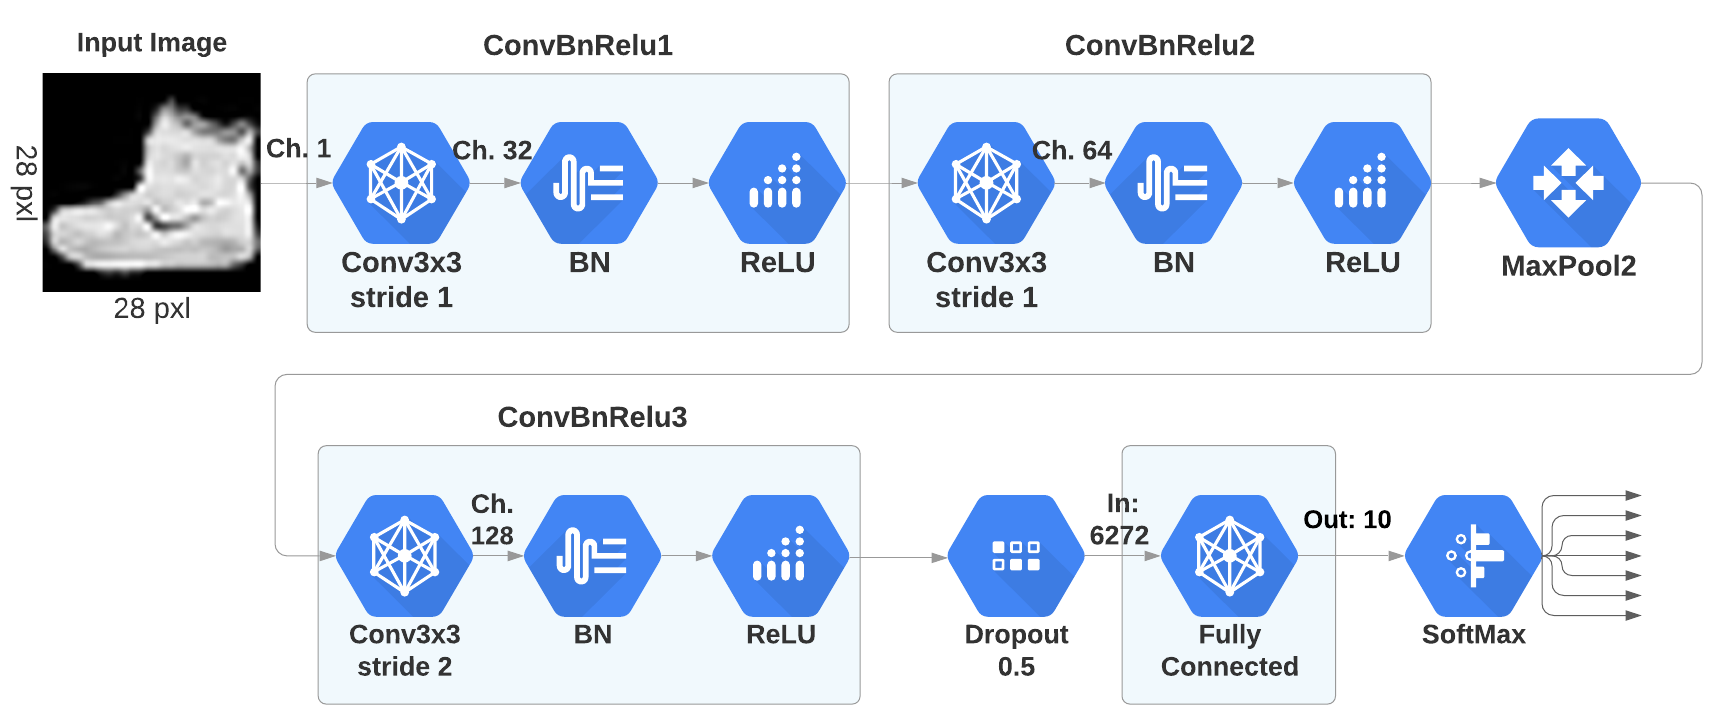

### This is how our network looks like:

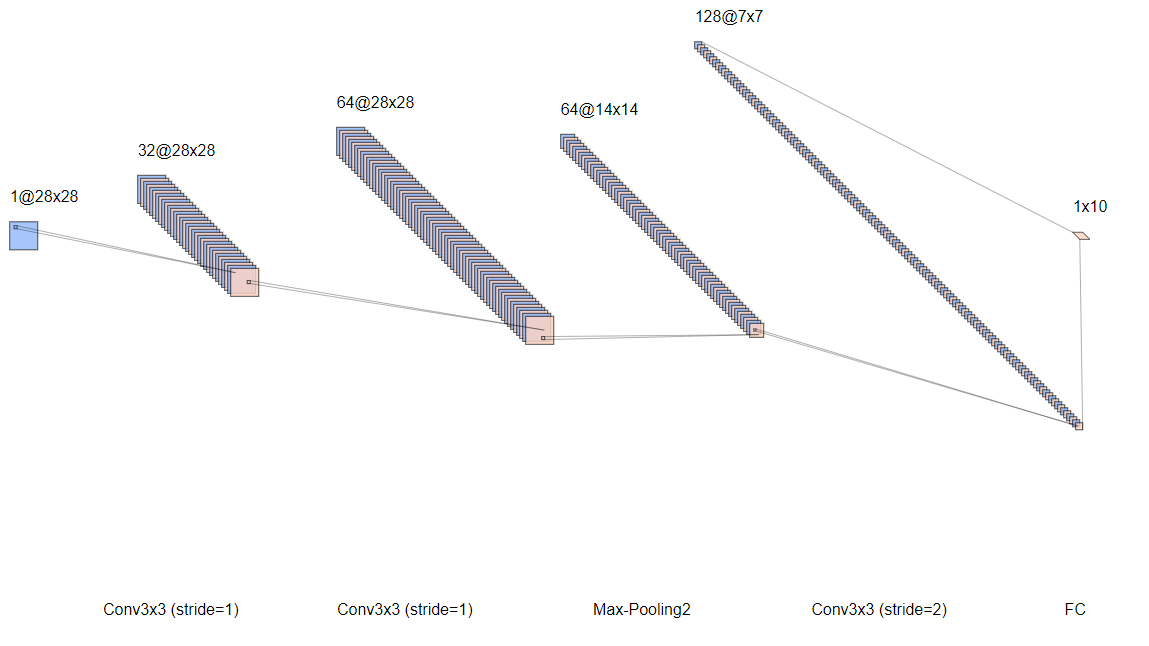

In [4]:
class CNN(nn.Module):
    def __init__(self, n_classes=10, depth_mult=1.):
        super(CNN, self).__init__()
        # ConvBnRelu1
        # input: 1 channel, 28x28 size
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1) #32 channels output
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()

        # ConvBnRelu2
        # input: 32 channels, 28x28 size
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) #64 channels output
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()

        # MAXPOOL
        # input: 64 channels, 28x28 size
        # output: 64 channels, 14x14 size
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # ConvBnRelu3
        # input: 64 channels, 14x14 size
        # output: 128 channels, 7x7 size! (because of stride 2 in conv3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1) #128 channels output, half size
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()

        # CLASSIFIER
        # Dropout
        self.dropout = nn.Dropout(p=0.5)
        # flatten
        self.flatten = nn.Flatten()
        # FC
        # input: 7x7x128 = 6272, output: 10 (number of classes)
        self.fc = nn.Linear(6272, 10)
        # Softmax
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # ConvBnRelu1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        # ConvBnRelu2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        # MAXPOOL
        x = self.maxpool(x)
        # ConvBnRelu3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        # Dropout
        x = self.dropout(x)
        #flatten
        x = self.flatten(x)
        # FC
        x = self.fc(x)
        # Softmax
        x = self.softmax(x)
        return x

net = CNN().to(device)


### Test defined network, and verify layers




In [5]:
#@title Dummy input  { form-width: "70%" }
# input_size = (batch_n, img_ch,img_width, img_height)
input_size = (1, 1, 28, 28)  #@param
input = torch.randn(input_size).to(device)#add one extra field to input size for batch_n


Print output tensor size and the CNN network topology defined:

In [6]:
output = net(input)
print('Output shape:', output.shape)
print('Network Topology:\n',net)

Output shape: torch.Size([1, 10])
Network Topology:
 CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=6272, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


# **Task 2:** Count network's parameters and MAC operations

---

Let's define a couple of useful functions to measure the model's MAC operations and number of parameters.
These two functions are equivalent !

In [7]:


def network_size_and_mac(net, input_size, verbose=False):
    # calculate from net
    x=torch.empty(input_size)
    x = x.to(device)
    macs, params = profile(net, inputs=(x,), verbose=verbose)

    print("Network's \tn°params: %.3fk \tMAC: %.3fM\n" % (params/1e3, macs/1e6))

network_size_and_mac(net, input_size) #use deepcopy to avoid graph modifications by hese function calls

Network's 	n°params: 155.850k 	MAC: 18.678M



**TorchInfo insights:**
This tool calculates the Parameters Size as (number_of_parameters*4).
This because each parameter needs 4 Bytes (32bit) to be represented in float32 format.

# **Task 3:** Dataset & DataLoaders

---

In this notebook we'll a custom CNN on the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist), which is a set of 28x28 grayscale images of clothes.
This dataset is provided by the [Torchvision package](https://pytorch.org/docs/stable/torchvision/index.html).

Before diving in, let's look at the Fashion MNIST dataset. The dataset has 6k training images and 1k validation images. It has a total of 10 classes, each represented by an integer index. The following cell creates a mapping from these indices to their corresponding human-readable strings, then downloads the Fashion MNIST training dataset from Torchvision. It may take a minute to run.

Torchvision provides easy access to many datasets, including COCO, CIFAR, and Cityscapes. See its documentation for a complete list.

The dataset is stored on the Colab VM in the `/data/fashionmnist` directory.


Optional: diplay one image from the dataset
This might help you!

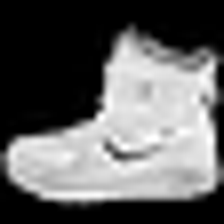

ankle boot


In [8]:
#@title Show dataset image samples
import torchvision.datasets as datasets

class_map = {
    0 : "t-shirt",
    1 : "trouser",
    2 : "pullover",
    3 : "dress",
    4 : "coat",
    5 : "sandal",
    6 : "shirt",
    7 : "sneaker",
    8 : "bag",
    9 : "ankle boot"
}

# Downloads the Fashion MNIST dataset using Torchvision
fashion_mnist_dataset = datasets.FashionMNIST(root='./data', download=True)

# show one image from dataset
img_index = 0 #@param {type:"integer"}
tup = fashion_mnist_dataset[img_index] # tup = (image, label)
display(tup[0].resize((224, 224)))
print(class_map[tup[1]])

In [9]:
type(fashion_mnist_dataset[0][0])

PIL.Image.Image

### Data loaders for Fashion MNIST



The code below first sets up transform using `torhvision transfroms` for converting images to pytorch tensors and normalizing the images.

Next, We use `torchvision datasets` for dowloading the fashion mnist dataset and applying transforms which we defined above.

* `train_dataset` contains the training data.
* `valid_dataset` contains the validation data

Next, We use `pytorch dataloader` for making dataloader from the train and validation sets.

In [10]:
def get_data_loaders(train_batch_size=128, val_batch_size=128, path='./data/fashionMNIST', verbose=False):
    #define data transformations
    #get images files from path (already downloaded)
    fashion_mnist = datasets.FashionMNIST(
          root="data",
          train=True,
          download=False,
          transform=transforms.ToTensor()
      )

    # Create a DataLoader to load the dataset in batches
    loader = torch.utils.data.DataLoader(fashion_mnist, batch_size=1000)

    # Compute the mean and standard deviation of the pixel values across all batches
    mean = 0.
    std = 0.
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)

    mean /= len(loader.dataset)
    std /= len(loader.dataset)

    # Define data transformations
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    # Load train/valid datasets
    #split into train and validation with a 80/20 ratio
    train_set= datasets.FashionMNIST(
        root="data",
        train=True,
        download=False,
        transform=data_transform
    )
    val_set= datasets.FashionMNIST(
        root="data",
        train=False,
        download=False,
        transform=data_transform
    )

    # define dataloaders
    train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True, num_workers=2)
    valid_loader = DataLoader(val_set, batch_size=val_batch_size, shuffle=False, num_workers=2)

    # count how many images we have in each set
    if verbose:
        print('Train set size:', len(train_set))
        print('Validation set size:', len(val_set))
        print('Train loader size:', len(train_loader))
        print('Validation loader size:', len(valid_loader))

    return train_loader, valid_loader

train_loader, val_loader = get_data_loaders(verbose=True)


Train set size: 60000
Validation set size: 10000
Train loader size: 469
Validation loader size: 79


#**Task 4:** testing the CNN over the dataset

---



### Accuracy Metric calculation

First we define a function to calculate the accuracy, defined as: `accuracy = num_correct_predictions/total_n_predictions`



In [11]:
def calculate_accuracy(best_guesses, targets):
    num_correct = sum(best_guesses == targets)
    total_guesses = len(best_guesses)
    correct_percentage = num_correct/total_guesses
    return correct_percentage

### Define Loss function: use cross entropy !

In [12]:
# Define loss function
# cross entropy works well for multi-class problems
loss_function = nn.CrossEntropyLoss()

### Testing Function
Before training we want to verify our data->network pipeline and set a baseline level of performance. The following cell defines a function, `validate,` that runs a network on a dataset and shows the percentage of the dataset that was correctly classified.

In [13]:
def validate(net, val_loader, loss_function, accuracy_score):
    # set net to evaluating (testing)
    net.eval()
    val_losses = []
    val_accuracy = []
    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader):
            inputs, labels = data[0].to(device), data[1].to(device)

            # net forward
            # this gets the prediction from the network
            outputs = net(inputs)

            # calculate loss
            loss = loss_function(outputs, labels)
            val_losses.append(loss.cpu()) # append current average training loss to a buffer variable, for plotting learning curve

            # calculate validation accuracy
            predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction
            accuracy = calculate_accuracy(predicted_classes.cpu(), labels.cpu())
            val_accuracy.append(accuracy)
            # val_accuracy.append(calculate_metric(accuracy_score, labels.cpu(), predicted_classes.cpu())) #this is the same accuracy calculated with scikitlearn

    average_val_loss = sum(val_losses)/(batch_idx+1)

    return val_accuracy, val_losses


In [14]:

val_accuracy, average_val_loss = validate(net, val_loader, loss_function, accuracy_score)
print('Accuracy: %0.2f'% (sum(val_accuracy)/len(val_accuracy)))

Accuracy: 0.09


# **Task 5:** Training Loop

---



**Basic training in PyTorch:**
- enumerates a dataset in batches
- runs the network on each batch
- evaluates the network's performance using a loss function
- use `net.zero_grad()` to reset the gradients before backpropagation.
- calls `backward()` on the loss to propagate gradients through the network
- uses an optimizer to `step()` and apply the gradients to the network's weights

In this case we'll use:
* **Loss Function:** [CrossEntropyLoss](https://pytorch.org/docs/master/nn.html#torch.nn.CrossEntropyLoss) since we have a classification problem.
* **Optimizer:** We'll use the [Adam](https://pytorch.org/docs/master/optim.html#torch.optim.Adam) optimizer since it's a very easy optimizer to use (no need to tweak hyperparameters).

**Loops:**
*   for loop over `epochs`: at the end of each epoch we calculate the validation accuracy
*   for loop over `training batches`: for each batch we backpropagate using the loss function

**Training step:**
- enumerates a dataset in batches
- runs the network on each batch
- evaluates the network's performance using a loss function
- use `net.zero_grad()` to reset the gradients before backpropagation.
- calls `backward()` on the loss to propagate gradients through the network
- uses an optimizer to `step()` and apply the gradients to the network's weights


```
Pseudo-code:
├─ for each epoch (enumerate):
│  ├── for each training batch:
│  │  ├── output = net(input)
│  │  ├── loss = (output,ground_truth)
│  │  ├── net.zero_grad()
│  │  ├── loss.backward()
│  │  ├── optimizer step()
│  │  ├── calculate training accuracy
│  │  └── print: training accuracy and loss
│  └── test on validation set: print accuracy
```

We'll only train for 5 epochs for timeliness. The following cell should take 4-5 minutes to run.

### **Note: why do we need to reset the gradients**
In PyTorch, for every mini-batch during the training phase, we typically want to explicitly set the gradients to zero (`net.zero_grads()`)before starting to do backpropragation (i.e., updating the Weights and biases) because PyTorch accumulates the gradients on subsequent backward passes. So, the default action has been set to accumulate (i.e. sum) the gradients on every `loss.backward()` call.

I f you don't reset them, the gradient would be a combination of the old gradient, which you have already used to update your model parameters, and the newly-computed gradient. It would therefore point in some other direction than the intended direction towards the minimum (or maximum, in case of maximization objectives).

**in a nutshell:** if you don’t clear the gradients, they will accumulate across multiple iterations of training. This can lead to incorrect gradients and slower convergence of the model. Therefore, it’s important to clear the gradients before computing the gradients for the current iteration.

check out: https://saturncloud.io/blog/why-do-we-need-to-call-zerograd-in-pytorch/


In [15]:
#@title Training parameters { form-width: "70%" }
epochs = 5 #@param {type:"integer"}
batch_size = 128 #@param {type:"integer"}

In [ ]:
# Move net to gpu:
net.to(device)

# Build Dataloaders
train_loader, val_loader = get_data_loaders(batch_size, batch_size)

def training(net, train_loader, val_loader, loss_function, epochs):
    # Define optimizer (adam)
    optimizer = optim.Adam(net.parameters())

    # Create lists to store training and validation history
    train_loss_history = []
    train_accuracy_history = []
    #these are only epoch-mean values (to use in final history plot)
    e_train_loss_history = []
    e_train_accuracy_history = []
    e_val_loss_history = []
    e_val_accuracy_history = []

    start_ts = time.time()

    # ----------------- TRAINING  -------------------- #
    # loop for every epoch (training + evaluation)
    for epoch in range(epochs):
        net.train() # set model to training
        # loop for every batch of images in the dataset
        for batch_idx, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)

            # Compute prediction (forward input in the model)
            outputs =  net(inputs)
            # Compute prediction error with the loss function
            loss = loss_function(outputs, labels)
            # gradients to zero for every batch of data
            optimizer.zero_grad()
            # Backpropagation
            loss.backward()
            # Optimizer step
            optimizer.step()

            #compute training loss
            train_loss_history.append(loss.cpu().detach().numpy())

            # calculate training accuracy
            predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction (max value in the output vector)
            train_acc = calculate_accuracy(predicted_classes.cpu(), labels.cpu())
            train_accuracy_history.append(train_acc)


        # ----------------- VALIDATION  ----------------- #
        val_acc, val_loss = validate(net, val_loader, loss_function, accuracy_score)
        e_val_accuracy_history.append(np.array(val_acc).mean())
        e_val_loss_history.append(np.array(val_loss).mean())
        # print training/validation Accuracy and Loss (mean of all current batch values for this epoch)
        print('Epoch: %d/%d: Train Loss: %.6f, train acc: %.2f%% || Val Loss: %.6f, Val Acc: %.2f%%' % (
            epoch+1, epochs,
            np.array(train_loss_history[epoch:epoch+1]).mean(), np.array(train_accuracy_history[epoch:epoch+1]).mean(),
            np.array(val_loss).mean(), np.array(val_acc).mean()))
        e_train_accuracy_history.append(np.array(train_accuracy_history[epoch:epoch+1]).mean())
        e_train_loss_history.append(np.array(train_loss_history[epoch:epoch+1]).mean())

    return e_train_loss_history, e_train_accuracy_history, e_val_loss_history, e_val_accuracy_history


In [17]:
train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history=training(net, train_loader, val_loader, loss_function, epochs)

Epoch: 1/5: Train Loss: 2.304240, train acc: 0.12% || Val Loss: 1.583651, Val Acc: 0.88%
Epoch: 2/5: Train Loss: 2.198914, train acc: 0.29% || Val Loss: 1.576085, Val Acc: 0.89%
Epoch: 3/5: Train Loss: 2.033364, train acc: 0.55% || Val Loss: 1.574711, Val Acc: 0.89%
Epoch: 4/5: Train Loss: 1.897202, train acc: 0.65% || Val Loss: 1.559358, Val Acc: 0.90%
Epoch: 5/5: Train Loss: 1.878784, train acc: 0.65% || Val Loss: 1.558034, Val Acc: 0.90%


We now re-evaluated our network's performance, and you will see an accuracy ~90%

### Plot training/validation loss
This is a good practice to track the training process.

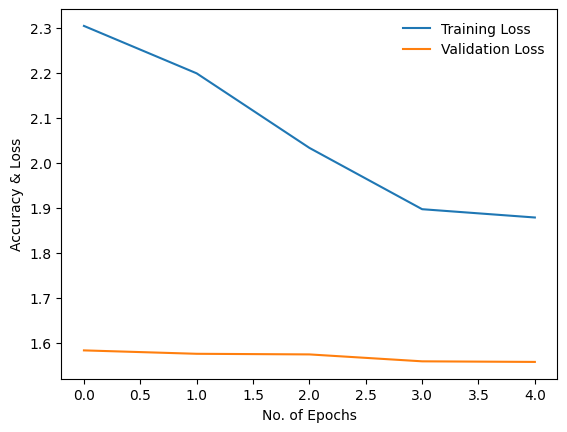

In [18]:
plt.plot(train_loss_history,label="Training Loss")
plt.plot(val_loss_history,label="Validation Loss")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy & Loss')
plt.legend(frameon=False)
plt.show()

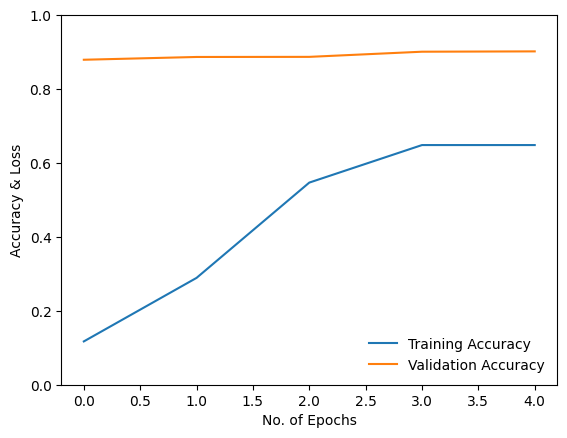

In [19]:

plt.plot(train_accuracy_history,label="Training Accuracy")
plt.plot(val_accuracy_history,label="Validation Accuracy")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy & Loss')
plt.ylim([0., 1.]) # limit y axis between 0 and 1
plt.legend(frameon=False)
plt.show()

# **Task 6:** Save/Load Model

---



In [20]:
#@title Training parameters { form-width: "70%" }
model_export_path = "./model/" #@param {type:"string"}
model_name = 'ExampleNet.pth' #@param {type:"string"}
os.makedirs(model_export_path, exist_ok=True)


### Save a PyTorch Model

In [21]:
#Save Pytorch model
def save_net(net,model_path, model_name):
    #Save Pytorch model
    torch.save(net.state_dict(), os.path.join(model_path, model_name))

save_net(net,model_export_path, model_name)

### Load a PyTorch Model

In [23]:
NEW_net = CNN().to(device)

# Load a PyTorch Model
def load_net(net, model_path, model_name, device):
    ''' Load a PyTorch Model '''
    # load weights file
    state_dict = torch.load(os.path.join(model_path, model_name), map_location=device)
    # Load weights into the network
    net.load_state_dict(state_dict, strict=False) #without "strict=False" I'm getting an error
    # to device (cpu or gpu)
    net = net.to(device)
    return net

load_net(NEW_net, model_export_path, model_name, device)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=6272, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

Test again the network accuracy, to be sure that you saved/loaded weights correctly. You should get ~90% accuracy again.

In [34]:
# Test over validation dataset
val_accuracy, average_val_loss = validate(NEW_net, val_loader, loss_function, accuracy_score)
# Print valid statistics
print("Average accuracy:", np.array(val_accuracy).mean())
print("Average loss:", np.array(average_val_loss).mean())


Average accuracy: 0.90189874
Average loss: 1.5580344


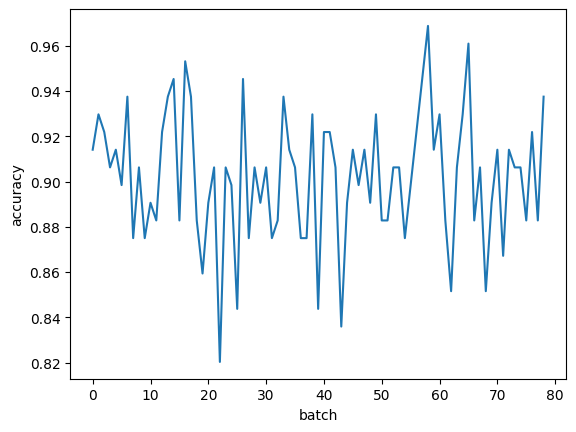

In [37]:
plt.plot(val_accuracy)
plt.xlabel("batch")
plt.ylabel("accuracy")
plt.show()

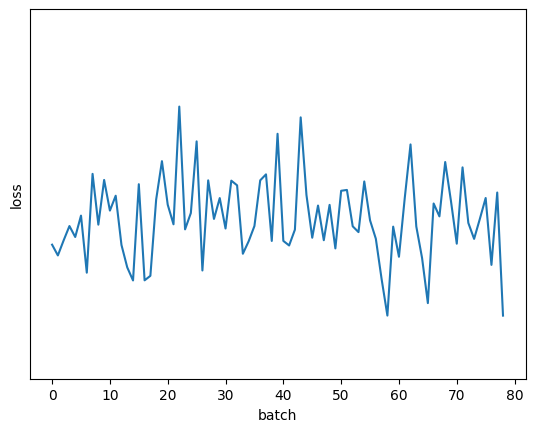

In [42]:
plt.plot(average_val_loss)
plt.plot("loss")
plt.xlabel("batch")
plt.ylabel("loss")
plt.ylim([1.45, 1.7])
plt.show()